# Conservative-to-Primitive Variable Transformation using Physics-Informed Neural Networks
# Clean implementation with improved architecture and training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

# Physics modules (assuming these are available)
from metric import metric
from hybrid_eos import hybrid_eos
from C2P_Solver import *
from pinn_arch import *
from pinn_arch_physics_guided import *

# Set up device and precision
use_fp64 = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64 if use_fp64 else torch.float32
torch.set_default_dtype(dtype)

print(f"Using device: {device}")
print(f"Using precision: {dtype}")

Using device: cuda
Using precision: torch.float64


In [2]:
# =============================================================================
# PHYSICS SETUP
# =============================================================================

# Minkowski metric 
eta = metric(
    torch.eye(3, device=device), 
    torch.zeros(3, device=device), 
    torch.ones(1, device=device)
)

# Gamma = 2 EOS with ideal gas thermal contribution 
eos = hybrid_eos(100, 2, 1.8)

In [3]:
def init_weights(m):
    """Xavier initialization for better training stability"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def prims_to_cons_normalized(rho, W, metric):
    """
    Generate conservative variables for cold matter
    """
    # Cold matter (T = 0)
    T = torch.zeros_like(rho, device=device)
    
    # EOS call
    press, eps = eos.press_eps__temp_rho(T, rho)

    if torch.isnan(press).any() or torch.isnan(eps).any():
        print("Warning: NaN values detected in pressure or energy density.")
        press = torch.where(torch.isnan(press), torch.tensor(0.0), press)
        eps = torch.where(torch.isnan(eps), torch.tensor(0.0), eps)
    
    # Compute conservative variables
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * (1 + eps) + press 
    g4uptt = -1 / metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2 - 1)) * rho0_h * W
    
    # Assemble conservative variables: [D, tau/D, S/D]
    C = torch.cat((
        dens.view(-1, 1) / metric.sqrtg,
        tau.view(-1, 1) / dens.view(-1, 1),
        S.view(-1, 1) / dens.view(-1, 1)
    ), dim=1)
    
    return C
# =============================================================================
# DATA GENERATION
# =============================================================================

def setup_initial_state_meshgrid_cold(metric, eos, N, device, 
                                      lrhomin=-12, lrhomax=-2.8, 
                                      Wmin=1.0, Wmax=2.0, bias_strength=2):
    """
    Generate conservative variables on a cold matter meshgrid
    """
    # Generate biased linspace: more points near edges using beta-like transformation
    def biased_linspace(a, b, n, bias_strength, endpoint=True, side='both'):
        t = torch.linspace(0, 1, n, device=device)
        if side == 'lower':
            t = t**bias_strength
        elif side == 'upper':
            t = 1 - (1 - t)**bias_strength
        elif side == 'both':  # 'both'
            t = 0.5 * ( (2*t)**bias_strength * (t < 0.5) + 
                        (2*(1 - t))**bias_strength * (t >= 0.5))
            t = torch.where(t < 0.5, t, 1 - t)
            t = 2 * t  # Rescale to [0,1]
        else : # none
            t=t
        return a + (b - a) * t
    # Create meshgrid
    W = torch.linspace(Wmin, Wmax, N, device=device)
    W = biased_linspace(Wmin, Wmax, N, bias_strength, side='both')
    rho = 10**(torch.linspace(lrhomin, lrhomax, N, device=device))
    
    rho_mesh, W_mesh = torch.meshgrid(rho, W, indexing='ij')
    
    # Flatten
    rho = rho_mesh.flatten()
    W = W_mesh.flatten() 
    
    # Cold matter (T = 0)
    T = torch.zeros_like(rho, device=device)
    
    # EOS call
    press, eps = eos.press_eps__temp_rho(T, rho)
    
    # Compute primitive z
    Z = torch.sqrt(1 - 1/W**2) * W 
    
    # Compute conservative variables
    sqrtg = metric.sqrtg 
    u0 = W / sqrtg 
    dens = sqrtg * W * rho 
    
    rho0_h = rho * (1 + eps) + press 
    g4uptt = -1 / metric.alp**2 
    Tuptt = rho0_h * u0**2 + press * g4uptt 
    tau = metric.alp**2 * sqrtg * Tuptt - dens 
    
    S = torch.sqrt((W**2 - 1)) * rho0_h * W
    
    # Assemble conservative variables: [D, tau/D, S/D]
    C = torch.cat((
        dens.view(-1, 1) / metric.sqrtg,
        tau.view(-1, 1) / dens.view(-1, 1),
        S.view(-1, 1) / dens.view(-1, 1)
    ), dim=1)
    
    return C, Z.view(-1, 1)


In [4]:
# =============================================================================
# DATASET CLASS
# =============================================================================

class C2P_Dataset(TensorDataset):
    """Dataset class with normalization capabilities"""
    
    def __init__(self, C, Z, normalize_data=True, margin=0.05):
        self.C = C.to(dtype)
        self.Z = Z.to(dtype)

        self.margin = margin
        
        if normalize_data:
            self.normalize()
        
    def normalize(self):
        """Min-max normalization"""
        self.C_max = torch.max(self.C, dim=0, keepdim=True)[0]
        self.C_min = torch.min(self.C, dim=0, keepdim=True)[0]
        self.C = (self.C - self.C_min) / (self.C_max - self.C_min)
        
        self.Z_max = torch.max(self.Z, dim=0, keepdim=True)[0]
        self.Z_min = torch.min(self.Z, dim=0, keepdim=True)[0]
        Z_range = self.Z_max - self.Z_min
        self.Z_min -= self.margin * Z_range
        self.Z_max += self.margin * Z_range

        self.Z = (self.Z - self.Z_min) / (self.Z_max - self.Z_min)
    
    def denormalize(self):
        """Reverse normalization"""
        self.C = self.C * (self.C_max - self.C_min) + self.C_min
        self.Z = self.Z * (self.Z_max - self.Z_min) + self.Z_min
    
    def __len__(self):
        return self.C.shape[0]

    def __getitem__(self, idx):
        return self.C[idx, :], self.Z[idx, :]

In [5]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    
    def __init__(self, in_dim, out_dim, activation, dtype=torch.float64):
        super().__init__()
        self.linear1 = nn.Linear(in_dim, out_dim, dtype=dtype)
        self.linear2 = nn.Linear(out_dim, out_dim, dtype=dtype)
        self.activation = activation
        
        # Skip connection (projection if dimensions don't match)
        if in_dim != out_dim:
            self.skip = nn.Linear(in_dim, out_dim, dtype=dtype)
        else:
            self.skip = nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        out = self.activation(self.linear1(x))
        out = self.linear2(out)
        return self.activation(out + identity)

class C2P_PINN(nn.Module):
    """
    Physics-Informed Neural Network for conservative-to-primitive transformation
    """
    
    def __init__(self, dtype=torch.float64, physics_weight=1.0):
        super().__init__()
        self.input_dim = 3
        self.hidden_dims = [384, 384, 192]
        self.activation = nn.SiLU()
        self.physics_weight = physics_weight
        
        # Define residual blocks
        layers = []
        in_dim = self.input_dim
        for out_dim in self.hidden_dims:
            layers.append(ResidualBlock(in_dim, out_dim, self.activation, dtype))
            in_dim = out_dim
        
        self.blocks = nn.Sequential(*layers)
        
        # Final layer with skip connection from original input
        self.final_fc = nn.Linear(self.hidden_dims[-1] + self.input_dim, 1, dtype=dtype)
        
        # Ensure positive output (physical constraint)
        self.output_activation = nn.Sigmoid()
        
        # Apply weight initialization
        self.apply(init_weights)
    
    def forward(self, x):
        """Forward pass with residual connections"""
        identity = x  # Keep original input for skip connection
        x = self.blocks(x)
        x = torch.cat([x, identity], dim=1)  # Concatenate with original input
        x = self.final_fc(x)
        return self.output_activation(x)
    
    def physics_loss(self, C, Z_pred, eos):
        """
        Physics-informed loss based on relativistic hydro constraints
        """
        # Your conservative variables are [D, τ/D, S/D]
        # The main physics constraint is the sanity check: Z = S/h̃
        
        # Convert back to physical conservative variables
        D = C[:, 0:1]  # Conserved density
        q = C[:, 1:2]  # τ/D 
        r = C[:, 2:3]  # S/D
        
        # Compute specific enthalpy from Z prediction
        try:
            htilde = h__z(Z_pred, C, eos)
            # Physics constraint: Z should equal r/htilde
            physics_residual = Z_pred - r / htilde
            return torch.mean(physics_residual**2)
        except:
            # If physics calculation fails, return zero loss
            return torch.tensor(0.0, device=C.device, dtype=C.dtype)

In [6]:
# =============================================================================
# LOSS FUNCTIONS
# =============================================================================

def log_cosh_loss(y_true, y_pred):
    """Robust loss function that's less sensitive to outliers"""
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))

def max_loss(y_true, y_pred):
    """Focus on harder examples"""
    max = torch.max(torch.abs(y_true - y_pred))
    return max

def huber_loss(y_true, y_pred, delta=1.0):
    """Huber loss for robust regression"""
    residual = torch.abs(y_true - y_pred)
    condition = residual <= delta
    squared_loss = 0.5 * (y_true - y_pred)**2
    linear_loss = delta * residual - 0.5 * delta**2
    return torch.mean(torch.where(condition, squared_loss, linear_loss))

def compute_loss(model, C, C_min, C_max, Z, Z_min, Z_max, eos=None, 
                physics_weight=1.0, loss_type='log_cosh'):
    """
    Compute combined data loss and physics loss
    """
    # Forward pass
    Z_pred = model(C)
    
    # Data fitting loss
    if loss_type == 'log_cosh':
        data_loss = log_cosh_loss(Z, Z_pred)
    elif loss_type == 'huber':
        data_loss = huber_loss(Z, Z_pred)
    elif loss_type == 'mse':
        data_loss = nn.MSELoss()(Z_pred, Z)
    elif loss_type == 'max':
        data_loss = max_loss(Z, Z_pred)
    else:
        data_loss = log_cosh_loss(Z, Z_pred)
    
    # Physics loss (if model supports it and parameters provided)
    physics_loss = 0.0
    if hasattr(model, 'physics_loss') and eos is not None:
        # Convert normalized inputs back to physical units for physics loss
        C_real = C * (C_max - C_min) + C_min
        Z_real = Z_pred * (Z_max - Z_min) + Z_min
        physics_loss = model.physics_loss(C_real, Z_real, eos)
    
    # Combined loss
    total_loss = data_loss + physics_weight * physics_loss
    
    return total_loss, data_loss, physics_loss

def compute_validation_loss(model, C, C_min, C_max, Z, Z_min, Z_max, eos):
    """
    Compute validation metrics including physical consistency checks
    """
    with torch.no_grad():
        Z_pred = model(C)
        
        # Convert back to physical units
        Z_pred_real = Z_pred * (Z_max - Z_min) + Z_min
        Z_real = Z * (Z_max - Z_min) + Z_min
        C_real = C * (C_max - C_min) + C_min
        
        # Physics consistency check
        err = sanity_check(Z_pred_real, C_real, eta, eos)
        
        return err

In [7]:
# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_pinn_model(model, optimizer, scheduler, training_loader, validation_loader,
                     C_min, C_max, Z_min, Z_max, num_epochs, eos, 
                     physics_weight=0.1, loss_type='log_cosh',
                     device='cpu', patience=50):
    """
    Train PINN model with comprehensive logging and early stopping
    """
    
    # Move model to device
    model = model.to(device)
    
    # Training history
    training_losses = []
    validation_losses = []
    physics_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    print(f"Training PINN for {num_epochs} epochs...")
    print(f"Physics weight: {physics_weight}, Loss type: {loss_type}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        epoch_physics_loss = 0
        
        for batch_idx, (C_data, Z_data) in enumerate(training_loader):
            C_data, Z_data = C_data.to(device), Z_data.to(device)
            
            optimizer.zero_grad()
            
            # Compute loss
            total_loss, data_loss, phys_loss = compute_loss(
                model, C_data, C_min, C_max, Z_data, Z_min, Z_max,
                eos, physics_weight, loss_type
            )
            
            # Backward pass
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            epoch_loss += total_loss.item()
            if isinstance(phys_loss, torch.Tensor):
                epoch_physics_loss += phys_loss.item()
        
        # Average losses
        epoch_loss /= len(training_loader)
        epoch_physics_loss /= len(training_loader)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for C_test, Z_test in validation_loader:
                C_test, Z_test = C_test.to(device), Z_test.to(device)
                
                val_err = compute_validation_loss(
                    model, C_test, C_min, C_max, Z_test, Z_min, Z_max, eos
                )
                
                val_loss += val_err.item()
        
        val_loss /= len(validation_loader)
        
        # Store history
        training_losses.append(epoch_loss)
        validation_losses.append(val_loss)
        physics_losses.append(epoch_physics_loss)
        
        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step()
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:4d} | "
                  f"Train Loss: {epoch_loss:.3e} | "
                  f"Val Loss: {val_loss:.3e} | "
                  f"Physics: {epoch_physics_loss:.3e} | "
                  f"LR: {current_lr:.2e}")
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.3e}")
    
    return {
        'training_losses': training_losses,
        'validation_losses': validation_losses,
        'physics_losses': physics_losses,
        'best_val_loss': best_val_loss
    }

# =============================================================================
# 6. ADVANCED TRAINING TECHNIQUES
# =============================================================================

import math
class CyclicLR(torch.optim.lr_scheduler._LRScheduler):
    """
    Cyclic learning rate for escaping local minima
    """
    def __init__(self, optimizer, base_lr=1e-6, max_lr=1e-3, step_size=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        super().__init__(optimizer)
    
    def get_lr(self):
        cycle = math.floor(1 + self.last_epoch / (2 * self.step_size))
        x = abs(self.last_epoch / self.step_size - 2 * cycle + 1)
        lr_scale = max(0, (1 - x))
        return [self.base_lr + (self.max_lr - self.base_lr) * lr_scale 
            for _ in self.base_lrs]



In [8]:
def plot_training_history(history):
    """Plot training curves for analysis"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training and validation loss
    axes[0, 0].semilogy(history['training_losses'], label='Training Loss')
    axes[0, 0].semilogy(history['validation_losses'], label='Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Physics loss
    axes[0, 1].semilogy(history['physics_losses'])
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Physics Loss')
    axes[0, 1].set_title('Physics-Informed Loss')
    axes[0, 1].grid(True)
    
    # Loss components comparison
    axes[1, 0].semilogy(history['training_losses'], label='Total Loss')
    axes[1, 0].semilogy(history['physics_losses'], label='Physics Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Loss Components')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Convergence analysis
    min_loss = min(history['validation_losses'])
    axes[1, 1].semilogy([min_loss] * len(history['validation_losses']), 
                        '--', label=f'Best Val Loss: {min_loss:.2e}')
    axes[1, 1].semilogy(history['validation_losses'], label='Validation Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Convergence Analysis')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def og_setup():
    C, Z = setup_initial_state_meshgrid_cold(eta, eos, 200, device,lrhomin=-6, lrhomax=-2.5, Wmin=1.2, Wmax=1.8)
    err = sanity_check(Z, C, eta, eos)
    print(f"Initial sanity check error: {err:.2e}")
    dataset = C2P_Dataset(C, Z)

    # Split into train/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    #model = C2P_PINN(dtype=dtype, physics_weight=0.1)
    model = FourierPINN(fourier_sigma=1, dtype=dtype)
    model = model.to(device)

    # Setup optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
C, Z = setup_initial_state_meshgrid_cold(eta, eos, 500, device, 
                                          lrhomin=-8, 
                                          lrhomax=-2.7, 
                                          Wmin=1.0, 
                                          Wmax=1.3,
                                          bias_strength=0)
err = sanity_check(Z, C, eta, eos)
print(f"Initial sanity check error: {err:.2e}")
dataset = C2P_Dataset(C, Z, margin=0.00)
    
# Split into train/validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create model
#model = C2P_PINN(dtype=dtype, physics_weight=0.1)
#model = FourierPINN(fourier_sigma=1, dtype=dtype)
#model = UltraCompactPINN(fourier_sigma=1.0, dtype=dtype)
#model = CompactFourierPINN(dtype=dtype)
from pinn_arch_physics_guided import PhysicsGuided_TinyPINNvKen
model = PhysicsGuided_TinyPINNvKen(dtype=dtype, correction_scale=0.2)
model = model.to(device)

# Setup optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=6, verbose=True
)
#simple_scheduler = SimpleAdaptiveLR(optimizer, factor=0.5, patience=3, reset_after=5, reset_factor=3.0)

#cycle_scheduler = CyclicLR(optimizer, base_lr=1e-7, max_lr=1e-3, step_size=50)

# Add this after creating your dataset:
print(f"C range after normalization: [{dataset.C.min():.6f}, {dataset.C.max():.6f}]")
print(f"Z range after normalization: [{dataset.Z.min():.6f}, {dataset.Z.max():.6f}]")
print(f"Original C_min: {dataset.C_min}")
print(f"Original C_max: {dataset.C_max}")
print(f"Original Z_min: {dataset.Z_min}")
print(f"Original Z_max: {dataset.Z_max}")

Initial sanity check error: 2.56e-31
C range after normalization: [0.000000, 1.000000]
Z range after normalization: [0.000000, 1.000000]
Original C_min: tensor([[1.0000e-08, 1.0000e-06, 0.0000e+00]], device='cuda:0')
Original C_max: tensor([[0.0026, 0.6635, 1.1595]], device='cuda:0')
Original Z_min: tensor([[0.]], device='cuda:0')
Original Z_max: tensor([[0.8288]], device='cuda:0')


/mnt/rafast/miler/python-env/pytorch/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


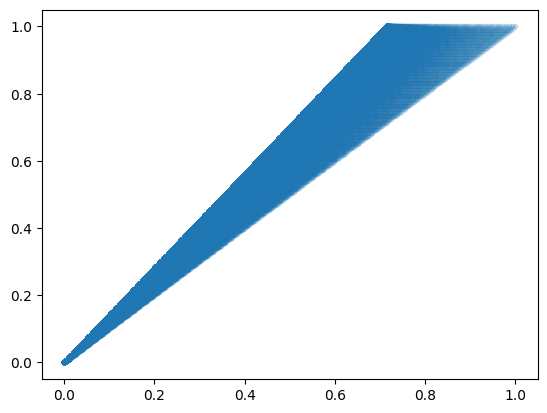

In [14]:
plt.plot(dataset.C[:,2].cpu().numpy(), dataset.Z[:,0].cpu().numpy(), '.', alpha=0.1)

In [10]:
history = train_pinn_model(
        model=model,
        optimizer=optimizer,
        scheduler=scheduler,
        training_loader=train_loader,
        validation_loader=val_loader,
        C_min=dataset.C_min,
        C_max=dataset.C_max,
        Z_min=dataset.Z_min,
        Z_max=dataset.Z_max,
        num_epochs=100,
        eos=eos,
        physics_weight=0.1,
        loss_type='max',
        device=device,
        patience=40
    )

/mnt/rafast/miler/python-env/pytorch/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Training PINN for 100 epochs...
Physics weight: 0.1, Loss type: max
------------------------------------------------------------
Epoch    0 | Train Loss: 9.673e-02 | Val Loss: 9.217e-04 | Physics: 2.264e-03 | LR: 5.00e-03
Epoch   10 | Train Loss: 4.740e-03 | Val Loss: 5.177e-06 | Physics: 4.574e-06 | LR: 5.00e-03
Epoch   20 | Train Loss: 4.013e-03 | Val Loss: 4.773e-07 | Physics: 3.774e-06 | LR: 5.00e-03
Epoch   30 | Train Loss: 1.918e-03 | Val Loss: 9.781e-07 | Physics: 8.959e-07 | LR: 1.25e-03
Epoch   40 | Train Loss: 9.696e-04 | Val Loss: 1.547e-07 | Physics: 1.780e-07 | LR: 1.25e-03
Epoch   50 | Train Loss: 4.788e-04 | Val Loss: 1.936e-08 | Physics: 3.713e-08 | LR: 3.13e-04
Epoch   60 | Train Loss: 4.756e-04 | Val Loss: 1.784e-08 | Physics: 3.886e-08 | LR: 3.13e-04
Epoch   70 | Train Loss: 3.605e-04 | Val Loss: 2.064e-08 | Physics: 1.951e-08 | LR: 1.56e-04
Epoch   80 | Train Loss: 3.607e-04 | Val Loss: 1.237e-08 | Physics: 2.032e-08 | LR: 1.56e-04
Epoch   90 | Train Loss: 3.037e-04

In [11]:
import h5py
print(f"Using h5py {h5py.version.version} with HDF5 {h5py.version.hdf5_version}")


def export_physics_guided_model_to_hdf5(model, filename, activation_name="tanh"):
    """Export PhysicsGuided_TinyPINNv3 model to HDF5 format for GRACE"""
    
    model.eval()
    
    with h5py.File(filename, 'w') as f:
        # Extract weights from correction_net
        state_dict = model.state_dict()
        
        # Get weights from the correction network layers
        weights_ih = state_dict['correction_net.0.weight'].detach().cpu().numpy()
        bias_h = state_dict['correction_net.0.bias'].detach().cpu().numpy()
        weights_ho = state_dict['correction_net.2.weight'].detach().cpu().numpy()
        bias_o = state_dict['correction_net.2.bias'].detach().cpu().numpy()
        
        # Store network parameters
        f.create_dataset('weights_input_to_hidden', data=weights_ih)
        f.create_dataset('bias_hidden', data=bias_h)
        f.create_dataset('weights_hidden_to_output', data=weights_ho)
        f.create_dataset('bias_output', data=bias_o)
        
        # Store metadata
        f.attrs['activation_function'] = activation_name
        f.attrs['input_size'] = weights_ih.shape[1]
        f.attrs['hidden_size'] = weights_ih.shape[0]
        f.attrs['output_size'] = weights_ho.shape[0]
        f.attrs['correction_scale'] = float(model.correction_scale)
        f.attrs['model_type'] = 'physics_guided'
        
        # Store normalization parameters from dataset
        f.create_dataset('input_min', data=dataset.C_min.cpu().numpy().flatten())
        f.create_dataset('input_max', data=dataset.C_max.cpu().numpy().flatten())
        f.create_dataset('output_min', data=dataset.Z_min.cpu().numpy().flatten())
        f.create_dataset('output_max', data=dataset.Z_max.cpu().numpy().flatten())
    
    print(f"Physics-guided model exported to {filename}")
    print(f"Architecture: {weights_ih.shape[1]} -> {weights_ih.shape[0]} -> {weights_ho.shape[0]}")
    print(f"Correction scale: {model.correction_scale}")
    
# Save the trained model
export_physics_guided_model_to_hdf5(
    model=model,
    filename='physics_guided_c2p_model_new.h5',
    activation_name="tanh"
)

Using h5py 3.14.0 with HDF5 2.0.0
Physics-guided model exported to physics_guided_c2p_model_new.h5
Architecture: 3 -> 64 -> 1
Correction scale: 0.2


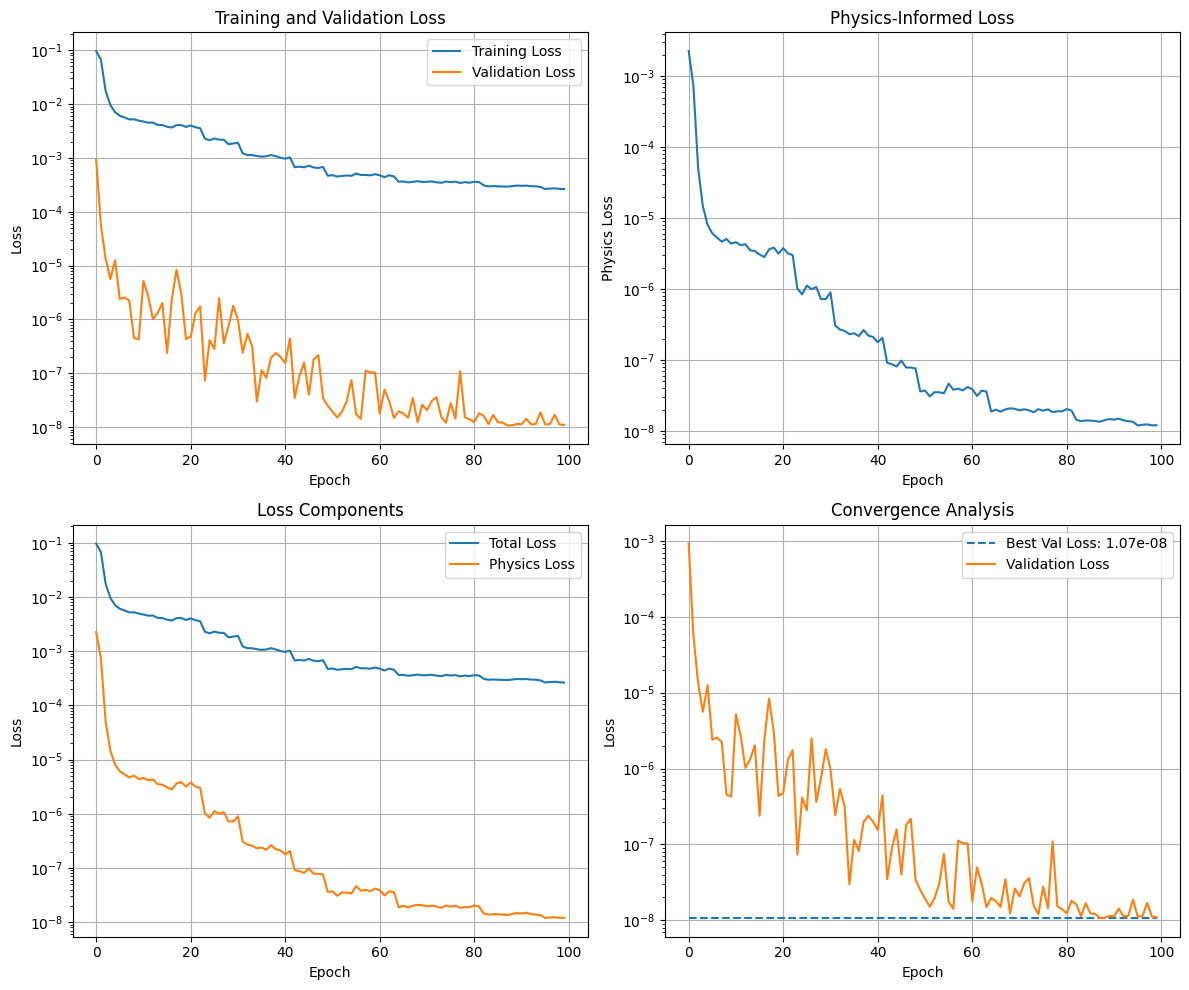

In [12]:
# Plot training results
plot_training_history(history)

Initial sanity check error: 1.47e-31
Solver device: cuda
Z_true shape: torch.Size([40000, 1])
Z_true sample: tensor([0.0000, 0.0078, 0.0156, 0.0234, 0.0311], device='cuda:0')
Test C range: [0.000000, 0.991137]
Test Z range: [0.000000, 0.825948]
Training C_min/max: tensor([1.0000e-08, 1.0000e-06, 0.0000e+00], device='cuda:0'), tensor([0.0026, 0.6635, 1.1595], device='cuda:0')
Training Z_min/max: 0.000000, 0.828781
Z_pred shape: torch.Size([40000, 1])
Z_pred sample: tensor([0.0001, 0.0079, 0.0156, 0.0233, 0.0311], device='cuda:0')


/mnt/rafast/miler/codes/Pinns/C2P_Solver.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C_min = torch.tensor(C_min, device=device, dtype=torch.float64)
/mnt/rafast/miler/codes/Pinns/C2P_Solver.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C_max = torch.tensor(C_max, device=device, dtype=torch.float64)
/mnt/rafast/miler/codes/Pinns/C2P_Solver.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Z_min = torch.tensor(Z_min, device=device, dtype=torch.float64)
/mnt/rafast/miler/codes/Pinns/C2P_Solver.py:57: UserWar

Figure saved to absolute_error_analysis_with_zeta.png


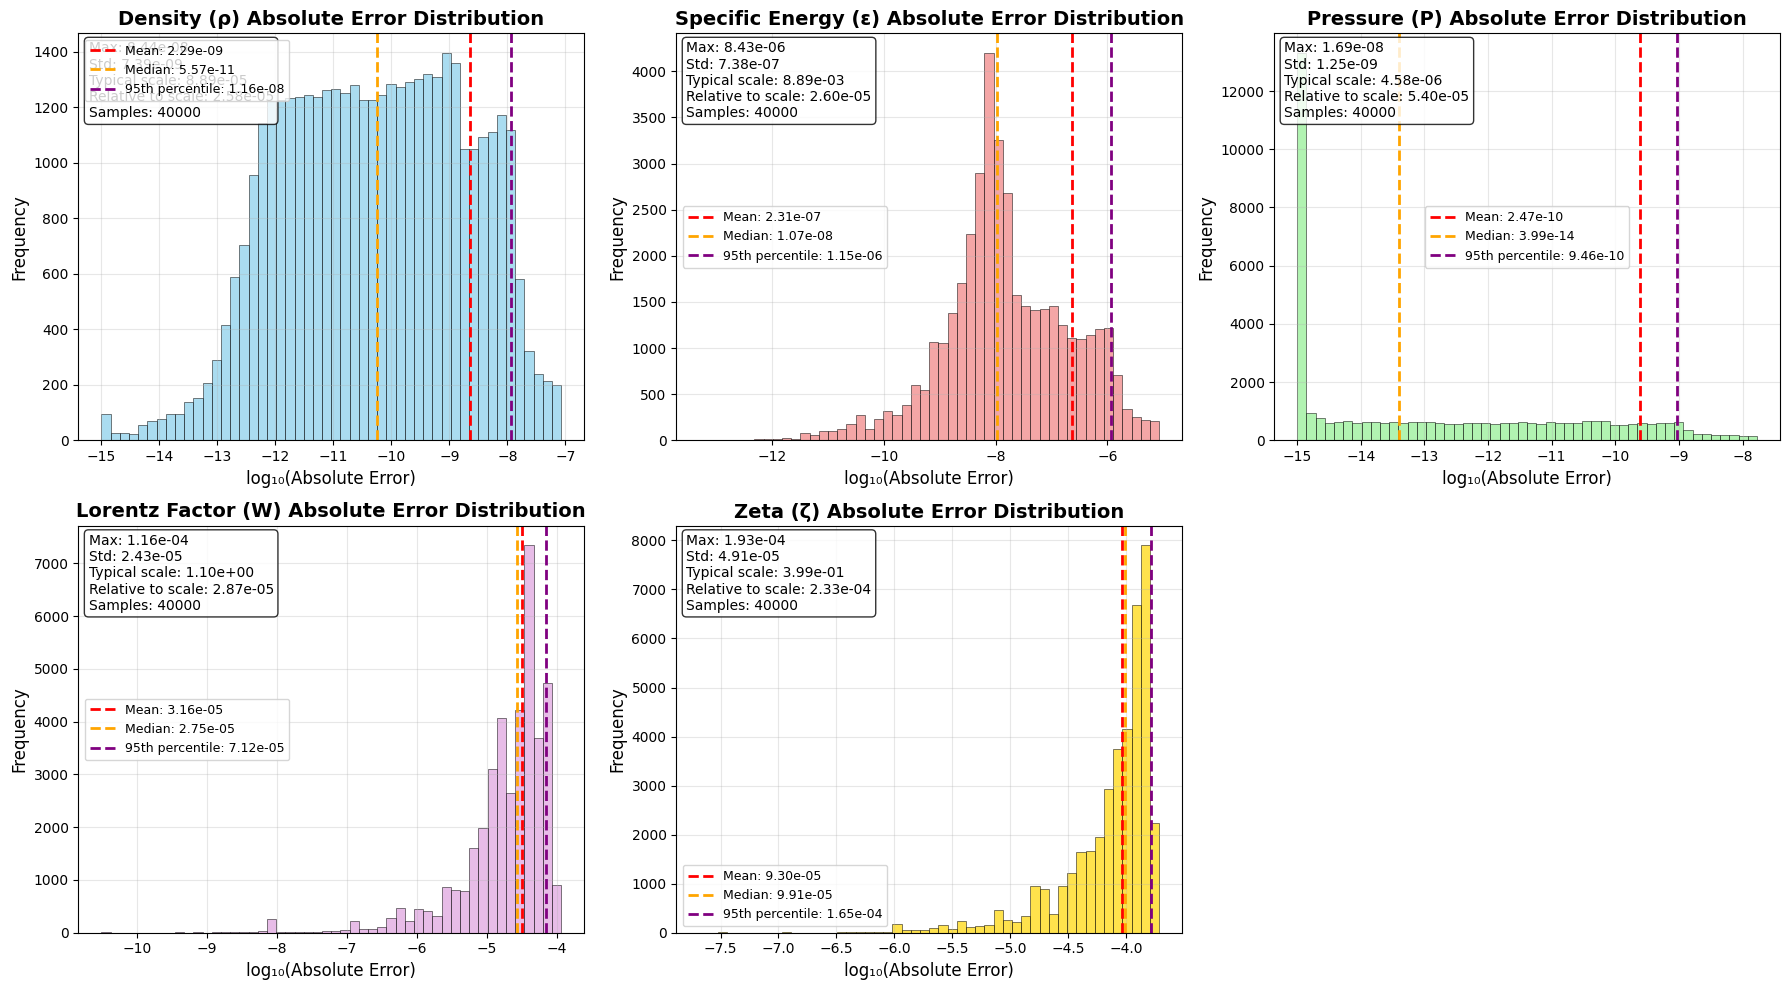


COMPREHENSIVE ABSOLUTE ERROR ANALYSIS SUMMARY (INCLUDING ZETA)

Density (ρ)         :
  Mean abs error:     2.29e-09
  Median abs error:   5.57e-11
  Std abs error:      7.39e-09
  Min abs error:      9.73e-17
  Max abs error:      8.44e-08
  95th percentile:    1.16e-08
  99th percentile:    4.16e-08
  Typical value scale: 8.89e-05
  Mean relative error: 2.58e-05
  Samples:            40000
  Quality breakdown (absolute thresholds):
    Excellent:   6290 ( 15.7%)
    Good:       31224 ( 78.1%)
    Fair:        2486 (  6.2%)
    Poor:           0 (  0.0%)

Specific Energy (ε) :
  Mean abs error:     2.31e-07
  Median abs error:   1.07e-08
  Std abs error:      7.38e-07
  Min abs error:      4.96e-14
  Max abs error:      8.43e-06
  95th percentile:    1.15e-06
  99th percentile:    4.15e-06
  Typical value scale: 8.89e-03
  Mean relative error: 2.60e-05
  Samples:            40000
  Quality breakdown (absolute thresholds):
    Excellent:   1352 (  3.4%)
    Good:       36166 ( 90.4%)


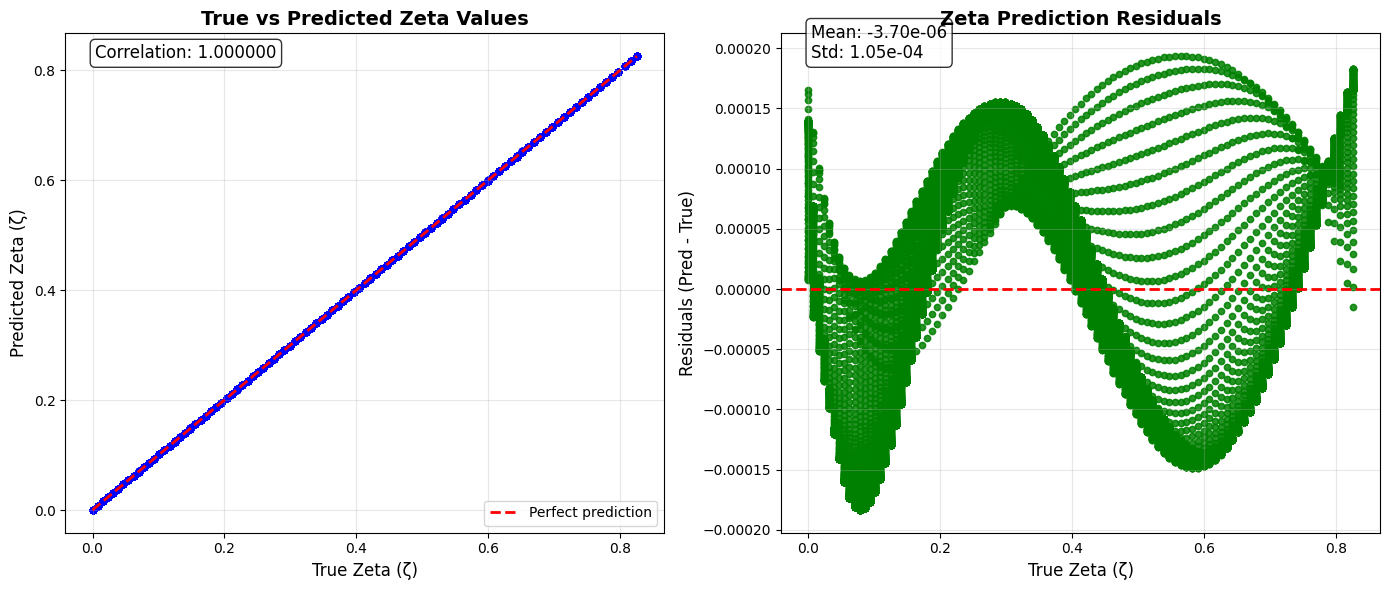

Zeta scatter analysis with density coloring saved to zeta_scatter_analysis_with_density.png


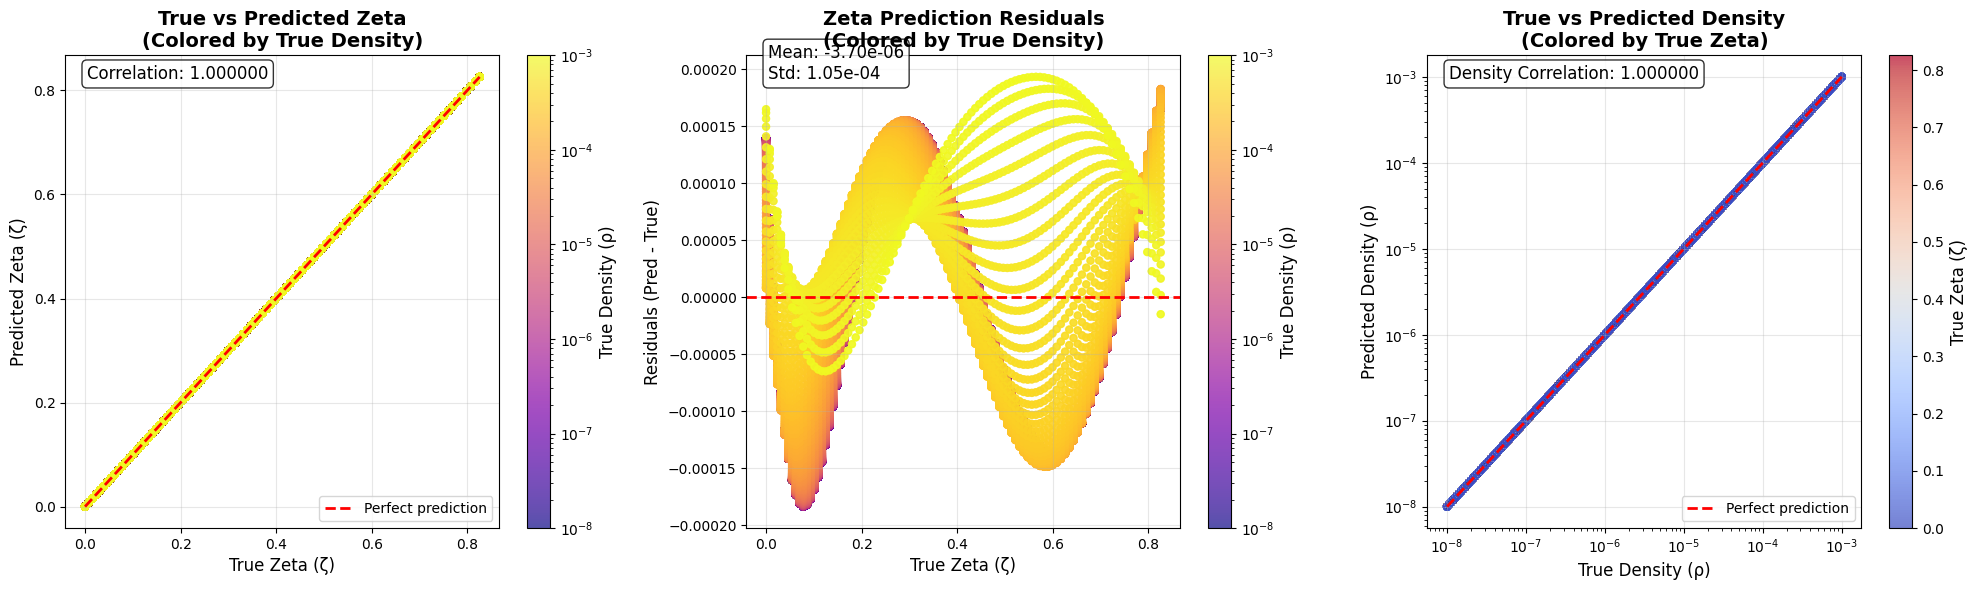


=== Analysis Summary ===
Zeta correlation: 1.000000
Density correlation: 1.000000
Residual mean: -3.70e-06
Residual std: 1.05e-04
Density range (true): 1.00e-08 to 1.00e-03
Zeta range (true): 0.000 to 0.826


In [13]:
from pinn_err_tests import plot_error_analysis_with_zeta_absolute, plot_zeta_scatter_analysis

C, Z = setup_initial_state_meshgrid_cold(eta, eos, 200, device, Wmin=1, Wmax=1.3, lrhomin=-8, lrhomax=-3.0)
err = sanity_check(Z, C, eta, eos)
print(f"Initial sanity check error: {err:.2e}")
dataset_val = C2P_Dataset(C, Z, normalize_data=False)

# Usage example:
solver = C2P_Solver(model, eos, dataset.C_min, dataset.C_max, 
                   dataset.Z_min, dataset.Z_max, device=device)
print(f"Solver device: {solver.device}")

# Run enhanced error analysis with zeta
errors, Z_pred, Z_true = plot_error_analysis_with_zeta_absolute(
    solver=solver,
    test_C=dataset_val.C,
    test_Z=dataset_val.Z,
    save_fig=True
)

# Additional zeta-specific scatter plot analysis
plot_zeta_scatter_analysis(Z_true, Z_pred, save_fig=True)
# After training your model and getting predictions

from pinn_err_tests import plot_zeta_scatter_analysis_with_density
plot_zeta_scatter_analysis_with_density(Z, Z_pred, C, eos, save_fig=True)

In [14]:
# Minkowski metric 
eta = metric(
    torch.eye(3, device=device), 
    torch.zeros(3, device=device), 
    torch.ones(1, device=device)
)

# Gamma = 2 EOS with ideal gas thermal contribution 
eos = hybrid_eos(100, 2, 1.8)

solver = C2P_Solver(
    model,
    eos,
    C_min=C.min().item(),
    C_max=C.max().item(),
    Z_min=Z.min().item(),
    Z_max=Z.max().item(),
    device=device
)

# Generate test data
test_C, test_Z = setup_initial_state_meshgrid_cold(eta, eos, 50, device, Wmin=1.2, Wmax=1.8)
test_dataset = C2P_Dataset(test_C, test_Z, normalize_data=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
model.to(device)

PhysicsGuided_TinyPINNvKen(
  (correction_net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [15]:
# Before calling solver.invert()
test_C = test_dataset.C  # Convert to float64 to match model
rho, eps, press, W = solver.invert(test_dataset.C) # returns (rho, eps, press, W)
C_from_prims = prims_to_cons_normalized(rho, W, eta)
print(test_C)
print(test_C.shape)
print(C_from_prims)
print(C_from_prims.shape)
print(test_C[abs(test_C - C_from_prims).argmax().item()//3])
print(C_from_prims[abs(test_C - C_from_prims).argmax().item()//3])

one_cons = test_C[abs(test_C - C_from_prims).argmax().item()//3]
rho_one, eps_one, press_one, W_one = solver.invert(one_cons.view(1, -1))
two_cons = prims_to_cons_normalized(rho_one, W_one, eta)
print("One conservative variable:", one_cons)
print(two_cons)

tensor([[1.2000e-12, 2.0000e-01, 6.6332e-01],
        [1.2010e-12, 2.0100e-01, 6.6513e-01],
        [1.2040e-12, 2.0400e-01, 6.7053e-01],
        ...,
        [1.9082e-03, 4.5400e-01, 8.8308e-01],
        [1.9035e-03, 4.4973e-01, 8.7596e-01],
        [1.9019e-03, 4.4830e-01, 8.7358e-01]], device='cuda:0')
torch.Size([2500, 3])
tensor([[1.2000e-12, 2.1564e-01, 6.9122e-01],
        [1.2010e-12, 2.1664e-01, 6.9297e-01],
        [1.2040e-12, 2.1963e-01, 6.9821e-01],
        ...,
        [1.9082e-03, 6.6075e-01, 1.2130e+00],
        [1.9035e-03, 6.5487e-01, 1.2048e+00],
        [1.9019e-03, 6.5291e-01, 1.2021e+00]], device='cuda:0')
torch.Size([2500, 3])
tensor([0.0024, 0.8544, 1.4527], device='cuda:0')
tensor([0.0024, 1.1702, 1.8542], device='cuda:0')
One conservative variable: tensor([0.0024, 0.8544, 1.4527], device='cuda:0')
tensor([[0.0024, 1.1702, 1.8542]], device='cuda:0')


In [16]:
# Let's trace through what SHOULD happen:
one_cons = test_C[abs(test_C - C_from_prims).argmax().item()//3]
print("Original conserved variables:", one_cons)

# What your solver returns:
rho_solver, eps_solver, press_solver, W_solver = solver.invert(one_cons.view(1, -1))
print(f"Solver returns: ρ={rho_solver.item():.6f}, W={W_solver.item():.6f}")

# What should give the correct reconstruction:
print("Testing different ρ, W combinations to see what would work...")


Original conserved variables: tensor([0.0024, 0.8544, 1.4527], device='cuda:0')
Solver returns: ρ=0.001331, W=1.773333
Testing different ρ, W combinations to see what would work...


In [17]:
import torch
import pickle
import json
from datetime import datetime
import os

def save_pinn_model(model, history, dataset, eos, eta, optimizer, scheduler, 
                   save_dir="saved_models", model_name=None):
    """
    Save the trained PINN model with all relevant features and metadata.
    
    Args:
        model: The trained PINN model
        history: Training history dictionary
        dataset: The C2P_Dataset used for training
        eos: Equation of state object
        eta: Physics parameter
        optimizer: The optimizer used
        scheduler: The learning rate scheduler used
        save_dir: Directory to save the model
        model_name: Optional custom name for the model
    """
    
    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate model name if not provided
    if model_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_name = f"pinn_model_{timestamp}"
    
    # Create full save path
    save_path = os.path.join(save_dir, model_name)
    
    # Prepare model state and metadata
    model_data = {
        # Model state
        'model_state_dict': model.state_dict(),
        'model_class': model.__class__.__name__,
        'model_config': {
            'dtype': str(model.dtype) if hasattr(model, 'dtype') else 'unknown',
            'correction_scale': getattr(model, 'correction_scale', None),
            'fourier_sigma': getattr(model, 'fourier_sigma', None),
            'physics_weight': getattr(model, 'physics_weight', None),
        },
        
        # Training configuration
        'training_config': {
            'batch_size': 256,  # From your code
            'num_epochs': 300,
            'physics_weight': 0.1,
            'loss_type': 'log_cosh',
            'patience': 40,
            'learning_rate': 1e-3,
            'weight_decay': 1e-5,
        },
        
        # Optimizer and scheduler state
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'optimizer_class': optimizer.__class__.__name__,
        'scheduler_class': scheduler.__class__.__name__ if scheduler else None,
        
        # Dataset information
        'dataset_info': {
            'C_min': dataset.C_min.cpu().numpy() if torch.is_tensor(dataset.C_min) else dataset.C_min,
            'C_max': dataset.C_max.cpu().numpy() if torch.is_tensor(dataset.C_max) else dataset.C_max,
            'Z_min': dataset.Z_min.cpu().numpy() if torch.is_tensor(dataset.Z_min) else dataset.Z_min,
            'Z_max': dataset.Z_max.cpu().numpy() if torch.is_tensor(dataset.Z_max) else dataset.Z_max,
            'dataset_size': len(dataset),
            'train_size': int(0.8 * len(dataset)),
            'val_size': len(dataset) - int(0.8 * len(dataset)),
        },
        
        # Initial state setup parameters
        'initial_setup': {
            'eta': eta,
            'grid_points': 600,
            'lrhomin': -11,
            'lrhomax': -1.8,
            'Wmin': 1.0,
            'Wmax': 2.0,
        },
        
        # Training history
        'training_history': history,
        
        # Metadata
        'metadata': {
            'save_timestamp': datetime.now().isoformat(),
            'pytorch_version': torch.__version__,
            'model_name': model_name,
            'device': str(next(model.parameters()).device),
        }
    }
    
    # Save the complete model data
    torch.save(model_data, f"{save_path}.pt")
    
    # Save EOS separately (in case it's not serializable with torch.save)
    try:
        with open(f"{save_path}_eos.pkl", 'wb') as f:
            pickle.dump(eos, f)
    except Exception as e:
        print(f"Warning: Could not save EOS object: {e}")
        # Save EOS information as text
        with open(f"{save_path}_eos_info.txt", 'w') as f:
            f.write(f"EOS class: {eos.__class__.__name__}\n")
            f.write(f"EOS attributes: {dir(eos)}\n")
    
    # Save a human-readable summary
    summary = {
        'model_name': model_name,
        'model_class': model.__class__.__name__,
        'training_epochs': len(history.get('train_loss', [])),
        'final_train_loss': history.get('train_loss', [])[-1] if history.get('train_loss') else None,
        'final_val_loss': history.get('val_loss', [])[-1] if history.get('val_loss') else None,
        'dataset_size': len(dataset),
        'save_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'physics_parameter_eta': eta,
    }
    
    with open(f"{save_path}_summary.json", 'w') as f:
        json.dump(summary, f, indent=2, default=str)
    
    print(f"Model saved successfully!")
    print(f"Main model file: {save_path}.pt")
    print(f"EOS file: {save_path}_eos.pkl")
    print(f"Summary file: {save_path}_summary.json")
    
    return save_path

# Save your model
#save_path = save_pinn_model(
#    model=model,
#    history=history,
#    dataset=dataset,
#    eos=eos,
#    eta=eta,
#    optimizer=optimizer,
#    scheduler=scheduler,
#    save_dir="saved_models",
#    model_name="physics_guided_tiny_pinn_v3"
#)

print(f"\nModel saved at: {save_path}")

# Function to load the model later
def load_pinn_model(model_path, device='cpu'):
    """
    Load a saved PINN model with all its features.
    
    Args:
        model_path: Path to the saved model file (without .pt extension)
        device: Device to load the model on
    
    Returns:
        dict: Dictionary containing model, metadata, and all saved features
    """
    # Load main model data
    model_data = torch.load(f"{model_path}.pt", map_location=device)
    
    # Load EOS if available
    eos = None
    try:
        with open(f"{model_path}_eos.pkl", 'rb') as f:
            eos = pickle.load(f)
    except FileNotFoundError:
        print("EOS file not found, EOS will be None")
    
    # Load summary
    summary = None
    try:
        with open(f"{model_path}_summary.json", 'r') as f:
            summary = json.load(f)
    except FileNotFoundError:
        print("Summary file not found")
    
    print(f"Loaded model: {model_data['model_class']}")
    print(f"Training epochs: {len(model_data['training_history'].get('train_loss', []))}")
    print(f"Dataset size: {model_data['dataset_info']['dataset_size']}")
    
    return {
        'model_data': model_data,
        'eos': eos,
        'summary': summary,
        'model_path': model_path
    }

# Example usage for loading:
# loaded_data = load_pinn_model("saved_models/physics_guided_tiny_pinn_v3", device=device)
# model_state = loaded_data['model_data']['model_state_dict']
# history = loaded_data['model_data']['training_history']

NameError: name 'save_path' is not defined

In [ ]:
import torch
from torchviz import make_dot

# Create model and dummy input
model = C2P_PINN()
x = torch.randn(1, 3, requires_grad=True,dtype=dtype)  # Batch size 1, 3 inputs

# Forward pass
y = model(x)

# Create visualization
dot = make_dot(y, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
dot.render("neural_network_graph", format="png")  # Saves as PNG
dot.view()  # Opens the image

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

: 

In [ ]:
#torch.save(model, 'full_fourier_model.pth')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 